# Predictive Maintenance

These models were built from handcrafted datasets from https://www.unikie.com/en/stories/predictive-maintenance-tutorial-data-scientists/.

This project was done with the intention of practising building various ML models for Predictive Maintenance purposes and compare their performances.

The first dataset contains measurements from various sensors of the gadgets.

The seconds dataset contains the failure time and the id of the failed gadget.



## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Importing the Datasets
1. The first dataset contains data about the measurement time and other other parameters of the machine
2. The second dataset contains data about the failure time

In [2]:
df_measurements = pd.read_csv('measurements.csv', parse_dates=['measurement_time'])
df_measurements = df_measurements.sort_values(by = ['measurement_time'], ascending=[True])
df_measurements.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11
0,2020-07-15,1,3,7,16.0,44.114437,NaN,NaN
336,2020-07-15,3,3,8,11.0,40.427740,NaN,NaN
168,2020-07-15,2,3,10,16.0,22.300000,NaN,NaN
840,2020-07-15,6,7,6,12.0,75.874521,NaN,NaN
672,2020-07-15,5,4,7,12.0,81.125342,NaN,NaN


In [3]:
df_failures = pd.read_csv('failures.csv', parse_dates=['failure_time'])
df_failures = df_failures.sort_values(by = ['failure_time'], ascending=[True])
df_failures.head()

,failure_time,gadget_id
52,2020-07-15 05:31:44.776014200,4
72,2020-07-15 05:48:58.383388460,5
53,2020-07-15 06:42:44.569051620,4
14,2020-07-15 07:11:50.319233260,2
39,2020-07-15 09:33:48.330967860,3


## Combine both datasets
Perform a left-join by matching failure time on nearest measurement time

In [4]:
df_combined = pd.merge_asof(df_measurements, df_failures, left_on = 'measurement_time', right_on =  'failure_time', 
                            by = 'gadget_id', direction = 'forward')

## Feature Engineering
1. Create a column that calculates the difference between the failure time and measurement time
2. Create a column that identifies failure that happened within an hour after measurement
3. Create a column that calculates 6 hour rolling standard deviation for the pressure
4. Create a column that calculates 6 hour rolling mean for the temperature

In [5]:
df_combined['time_to_fail'] = df_combined['failure_time'] - df_combined['measurement_time']
df_combined['fail_in_1h'] = np.where(df_combined['time_to_fail'] < pd.Timedelta(hours=1), 1, 0)
df_combined = df_combined.reset_index(drop=True)
df_combined = df_combined.sort_values(by=['gadget_id', 'measurement_time'], ascending=[True, True])

In [6]:
df_combined['temperature_6h_std'] = df_combined.groupby('gadget_id')['temperature'].rolling(6).std(ddof=0).reset_index(drop=True)
df_combined['pressure_6h_mean'] = df_combined.groupby('gadget_id')['pressure'].rolling(6).mean().reset_index(drop=True)

In [7]:
df_combined.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time,time_to_fail,fail_in_1h,temperature_6h_std,pressure_6h_mean
0,2020-07-15 00:00:00.000,1,3,7,16.0,44.114437,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 09:56:03.974006640,0,NaN,NaN
7,2020-07-15 01:00:00.000,1,8,3,12.0,34.395177,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 08:56:03.974006640,0,3.453742,15.500000
13,2020-07-15 01:59:59.990,1,10,8,20.0,38.280705,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 07:56:03.984006640,0,3.803752,16.833333
18,2020-07-15 02:59:59.985,1,6,5,20.0,41.878215,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 06:56:03.989006640,0,3.679122,15.166667
25,2020-07-15 03:59:59.980,1,6,9,16.0,39.257268,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 05:56:03.994006640,0,9.337838,13.000000


## Prepare Training and Testing Dataset

In [8]:
X = ['vibration_y', 'pressure_6h_mean', 'temperature_6h_std']
y = ['fail_in_1h']
cols1 = X + y

df_main = df_combined.dropna(subset=cols1).reset_index(drop=True)

In [9]:
binner = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
df_binned = pd.DataFrame(binner.fit_transform(df_main[X]))

X = list(df_binned.columns)
cols2 = X + y

In [10]:
df_main = pd.concat([df_main, df_binned], axis=1)

df_train = df_main[df_main['gadget_id'].isin([1,2,3,4])].reset_index(drop=True)
df_test = df_main[df_main['gadget_id'].isin([5,6])].reset_index(drop=True)

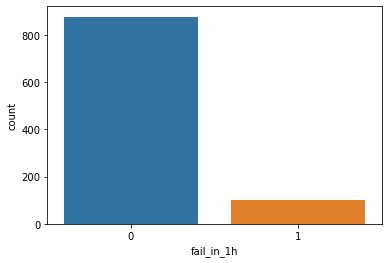

In [11]:
ax = sns.countplot(x="fail_in_1h", data=df_main)

# Prediction Models

In [12]:
w0 = 1
w1 = 9
pos_label = 1

## Neural Network

In [13]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10), random_state=1, max_iter=10000, activation='relu',
                   tol=0.00001)
nn.fit(df_train[X], df_train[y])
df_test['nn'] = nn.predict(df_test[X])

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Random Forest 

In [14]:
random_forest = RandomForestClassifier(min_samples_leaf=7, random_state=45, n_estimators=50, class_weight={0:w0, 1:w1})
random_forest.fit(df_train[X], df_train[y])
df_test['random_forest'] = random_forest.predict(df_test[X])

<ipython-input-14-cff874273d7f>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(df_train[X], df_train[y])


## Random Forest with Random Search Cross Validation

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# The degree of penalization for each class
class_weight = [{0: 1, 1: 8},{0: 1, 1: 9},{0: 1, 1: 10}]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}
pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': [{0: 1, 1: 8}, {0: 1, 1: 9}, {0: 1, 1: 10}],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(df_train[X], df_train[y])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [{0: 1, 1: 8},
                                                         {0: 1, 1: 9},
                                                         {0: 1, 1: 10}],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                       

In [17]:
df_test['tuned_random_forest'] = rf_random.predict(df_test[X])

In [18]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'class_weight': {0: 1, 1: 8},
 'bootstrap': True}

## Random Forest with Grid Search with Cross Validation

In [19]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120, 130],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [1900, 2000, 2100],
    'class_weight': [{0: 1, 1: 7},{0: 1, 1: 8},{0: 1, 1: 9}]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [20]:
# Fit the grid search to the data
grid_search.fit(df_train[X], df_train[y])

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  7.1min finished
C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': [{0: 1, 1: 7}, {0: 1, 1: 8},
                                          {0: 1, 1: 9}],
                         'max_depth': [90, 100, 110, 120, 130],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [1900, 2000, 2100]},
             verbose=2)

In [21]:
df_test['gridsearch_random_forest'] = grid_search.predict(df_test[X])

## Logistic Regression Model

In [22]:
log_reg = LogisticRegression(class_weight={0:w0, 1:w1})
log_reg.fit(df_train[X], df_train[y])
df_test['log_reg'] = log_reg.predict(df_test[X])

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## KNN 

In [23]:
def knn_weights(knn_y):
    return np.where(knn_y==1, w1, w0)

knn = KNeighborsClassifier(weights = knn_weights)
knn.fit(df_train[X], df_train[y])
df_test['knn'] = knn.predict(df_test[X])

<ipython-input-23-1c54ad6e561e>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(df_train[X], df_train[y])


## SVM

In [24]:
svm = SVC(class_weight={0:w0, 1:w1}, C=1, random_state=42, kernel='linear')
svm.fit(df_train[X], df_train[y])
df_test['svm'] = svm.predict(df_test[X])

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Naive Bayes

In [25]:
bayes = GaussianNB()
bayes.fit(df_train[X], df_train[y])
df_test['bayes'] = bayes.predict(df_test[X])

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Results

In [26]:
model_summary = []
models = ['random_forest', 'tuned_random_forest', 'gridsearch_random_forest','log_reg', 'knn', 'nn', 'svm', 'bayes']

for m in models:
    precision = precision_score(df_test['fail_in_1h'], df_test[m], zero_division=0, pos_label=pos_label)
    recall = recall_score(df_test['fail_in_1h'], df_test[m], pos_label=pos_label)

    model_summary.append({
        'model': m,
        'precision': precision,
        'recall': recall
    })
    
df_summary = pd.DataFrame(model_summary)
df_summary        

,model,precision,recall
0,random_forest,0.310680,1.0000
1,tuned_random_forest,0.318841,0.6875
2,gridsearch_random_forest,0.323529,0.6875
3,log_reg,0.300000,0.9375
4,knn,0.500000,0.1875
5,nn,0.400000,0.1875
6,svm,0.303030,0.9375
7,bayes,0.303030,0.9375


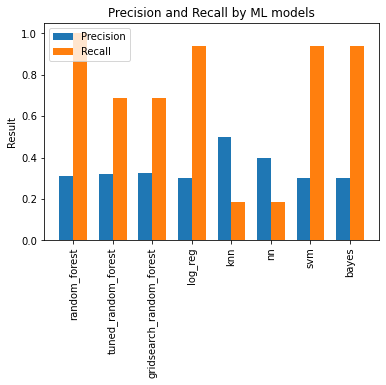

In [28]:
x = np.arange(len(df_summary['model']))
width = 0.35

plt.bar(x - width/2, df_summary['precision'], width, label = 'Precision')
plt.bar(x + width/2, df_summary['recall'], width, label = 'Recall')

plt.ylabel('Result')
plt.title('Precision and Recall by ML models')
plt.xticks(x, df_summary['model'])
plt.xticks(rotation=90)
plt.legend()
plt.show()
#fig.tight_layout()

Precision explains the percentage of failure predictions that were correct.

Recall explains the percentage of failures that the model captured.

Ideally we would want target for high precision and high recall. 

However, since these are dummy data, it included wicked fake patterns and randomness that would be difficult to capture without exact thresholds.



Nevertheless, the aim of this project is to practise implementing various models to the data and then, tune the models using Grid Search CV and to acquire improvise the performance. 